# Show me your plate and I tell you who you are

#### Unified Package Loading Prelude

In [306]:
import pickle as pkl 
import pandas as pd 
import numpy as np 
import statsmodels as sml
import math 
from scipy import stats
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
import itertools as it 

In [ ]:
### In Case we need it, load using the GeoPandas Kernel
import geopandas as gpd

In [9]:
### Association Rule Mining Packags
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules as arule


#### Doing an inverse Margaret Thatcher (Not reviving Irish though)

In [299]:
# Simple adaptable Model Pipeline Factory
def pipeline_factory(scaler, model, x_train, y_train, verbose = True):
    
    pipeline = Pipeline(steps = [
        ('scaler',  scaler),
        ('regressor',   model)
        ], verbose = verbose)
        
    pipeline.fit(x_train,y_train)
    return pipeline


In [289]:
# Generates Correlation Bar plots for different input parameters
# Returns a Fig and can optionally automaically write to the Website HTML Plot Repo. (Automatic Commit, Pull, Push and Deployment WIP) 
# Still need to Add Plot to index.md in later case, for it to show.

def bar_plot_factory(dataframe,category_socio_economics, category_nutrion, html_name = "", output_html = False, auto_commit = False):
    
    # Make a double column plot for more than 3 categories
    if len(category_socio_economics) > 3:
        cols = 2 
        rows = math.ceil(len(category_socio_economics)/2)
    else:
        cols = 1
        rows = len(category_socio_economics)
    
        
    fig = make_subplots(rows=rows, cols=cols,subplot_titles=([label_processor(x) for x in category_socio_economics]))
                                                             
    for cat_soc, index in zip(category_socio_economics, it.product(range(1, rows + 1), range(1, cols + 1))) :
       
        correl = [(nutr, stats.spearmanr(a = dataframe[cat_soc], b = dataframe[nutr]).correlation) for nutr in category_nutrion if stats.spearmanr(a = dataframe[cat_soc], b = dataframe[nutr]).pvalue < 0.05]

        fig.add_trace(go.Bar(x=[label_processor(c[0]) for c in correl if c[1] >= 0], y=[c[1] for c in correl if c[1] >= 0],
                            marker_color= color_tesco_blue,
                            name='positives'), row = index[0], col = index[1])

        fig.add_trace(go.Bar(x=[label_processor(c[0]) for c in correl if c[1] < 0], y=[c[1] for c in correl if c[1] < 0],
                            marker_color= color_tesco_red,
                            name='negatives'), row = index[0], col = index[1])
    
        fig.update_layout(showlegend=False)
        
        
    if output_html:
        print("Writing HTML to Repo...")
        fig.write_html("../fierceeagle.github.io/_includes/"+ html_name+".html")
        print("Ave Imperator, morituri te salutant")
        
        # Calling Systems Command in a Jupyter Notebook (Trust me I am an Engineer)
        if auto_commit: 
            %cd -q ../fierceeagle.github.io/
            # Adds the Plot if new Name
            print("Adding new Files ...")
            !git add *.html
            print("Commiting Changes ...")
            !git commit -m"Added/Changed Plot" --quiet
            print("Pulling previous Changes ... ")
            !git pull --quiet
            print("Pushing to Remote...")
            !git push --quiet
            print("Finished")
    
    return fig

In [290]:
# Genrates an interactive 3D Plot and generate an HTML 
def three_D_plot_factory(dataframe,x_axis, y_axis, z_axis,quantiles, aggfunc, title = "", x_title ="",  y_title = "", z_title = "", html_name = "", output_html = False, auto_commit = False):
    
    slice_df = dataframe[[x_axis] + [y_axis] + [z_axis]].copy()
    slice_df[x_axis] = pd.qcut(x = slice_df[x_axis], q = quantiles)
    slice_df[y_axis] = pd.qcut(x = slice_df[y_axis], q = quantiles)
    pivot_slice_df = slice_df.pivot_table(index = x_axis,columns = y_axis, values = z_axis, aggfunc = aggfunc)

    imputer = KNNImputer(n_neighbors=3)
    pivot_slice_df = pd.DataFrame(imputer.fit_transform(pivot_slice_df), columns = pivot_slice_df.columns, index = pivot_slice_df.index)
    fig = go.Figure(
        data=go.Surface(z=pivot_slice_df.values),
            layout=go.Layout(
            ))

    fig.update_layout(
            title=title,
            scene = dict(
                        xaxis = dict(
                            title = x_title,
                            nticks = len(pivot_slice_df.columns.tolist()),
                            tickvals = list(range(len(pivot_slice_df.columns.tolist()))), 
                            ticktext= ["{:.1f}".format((x.left + x.right)/2) for x in pivot_slice_df.columns.tolist()]),
                        yaxis = dict(
                            title = y_title,
                            nticks = len(pivot_slice_df.index.tolist()),
                            tickvals = list(range(len(pivot_slice_df.index.tolist()))), 
                            ticktext= ["{:.0f}".format((x.left + x.right)/2) for x in pivot_slice_df.index.tolist()]),
                        zaxis_title= z_title),
                        margin=dict(r=40, b=40, l=40, t=40)
            )
        
    if output_html:
        print("Writing HTML to Repo...")
        fig.write_html("../fierceeagle.github.io/_includes/"+ html_name+".html")
        print("Ave Imperator, morituri te salutant")
        
        # Calling Systems Command in a Jupyter Notebook (Trust me I am an Engineer)
        if auto_commit: 
            %cd -q ../fierceeagle.github.io/
            # Adds the Plot if new Name
            print("Adding new Files ...")
            !git add *.html
            print("Commiting Changes ...")
            !git commit -m"Added/Changed Plot" --quiet
            print("Pulling previous Changes ... ")
            !git pull --quiet
            print("Pushing to Remote...")
            !git push --quiet
            print("Finished")
    
    return fig

In [291]:
# Genrates an interactive 3D Plot and generate an HTML that can be automatically pushed to the Website. Magic! 
def three_D_multi_plot_factory(dataframe,x_axis, y_axis, category_z ,quantiles, aggfunc, title = "", x_title ="",  y_title = "", z_title = "", html_name = "", output_html = False, auto_commit = False):
    
    if len(category_z) > 3:
        cols = 2 
        rows = math.ceil(len(category_z)/2)
        [[{'is_3d': True},{'is_3d': True}] for x in range(rows)]
    else:
        cols = len(category_z)
        rows = 1
        specs = [[{'is_3d': True} for x in range(cols)]]
        
    fig = make_subplots(rows=rows, cols=cols,subplot_titles=([label_processor(x) for x in category_z]), specs= specs, shared_xaxes = True, shared_yaxes = True)

    for z_axis, index in zip(category_z, it.product(range(1, rows + 1), range(1, cols + 1))) :
        slice_df = dataframe[[x_axis] + [y_axis] + [z_axis]].copy()
        slice_df[x_axis] = pd.qcut(x = slice_df[x_axis], q = quantiles)
        slice_df[y_axis] = pd.qcut(x = slice_df[y_axis], q = quantiles)
        pivot_slice_df = slice_df.pivot_table(index = x_axis,columns = y_axis, values = z_axis, aggfunc = aggfunc)

        imputer = KNNImputer(n_neighbors=3)
        pivot_slice_df = pd.DataFrame(imputer.fit_transform(pivot_slice_df), columns = pivot_slice_df.columns, index = pivot_slice_df.index)
        
        fig.add_trace(go.Surface(
                      z   = pivot_slice_df.values,
                      showlegend= False,
                      showscale=False,
                      ),row = index[0], col = index[1])
    
    fig.update_layout(title = title, 
                          scene = dict(
                                xaxis = dict(
                                    title = x_title,
                                    nticks = len(pivot_slice_df.columns.tolist()),
                                    tickvals = list(range(len(pivot_slice_df.columns.tolist()))), 
                                    ticktext= ["{:.1f}".format((x.left + x.right)/2) for x in pivot_slice_df.columns.tolist()]),
                                yaxis = dict(
                                    title = y_title,
                                    nticks = len(pivot_slice_df.index.tolist()),
                                    tickvals = list(range(len(pivot_slice_df.index.tolist()))), 
                                    ticktext= ["{:.0f}".format((x.left + x.right)/2) for x in pivot_slice_df.index.tolist()]),
                                zaxis_title= z_title),
                          margin=dict(r=40, b=40, l=40, t=40)) 
    
    if output_html:
        print("Writing HTML to Repo...")
        fig.write_html("../fierceeagle.github.io/_includes/"+ html_name+".html")
        print("Ave Imperator, morituri te salutant")
        
        # Calling Systems Command in a Jupyter Notebook (Trust me I am an Engineer)
        if auto_commit: 
            %cd -q ../fierceeagle.github.io/
            # Adds the Plot if new Name
            print("Adding new Files ...")
            !git add *.html
            print("Commiting Changes ...")
            !git commit -m"Added/Changed Plot" --quiet
            print("Pulling previous Changes ... ")
            !git pull --quiet
            print("Pushing to Remote...")
            !git push --quiet
            print("Finished")
    
    return fig

#### Defining some support functions making all the String Processing we need once and never again

In [300]:
## Process a column Label to Look nice in a Plot
def label_processor(label): 
    
    # eth columns
    if "ethnicity" in label:
        label = label.split("ethnicity_")[1].replace("_2011", "").capitalize()
        
        if "Bame" in label: 
            label = label.replace("Bame", "BAME")
        if "Other" in label:
            label = label.replace("Other", "Other Ethnicites")
        
    # edu columns
    elif "qualification" in label:
        label = label.replace("qualification_", "", 1).replace("_2011", "").replace("_", " ").capitalize() 
        
        if "Level" in label:
            label = label + " Qualification"
    # income columns  
    elif "annual" in label: 
        label = label.split("annual_")[1].replace("_", " ").capitalize()
        
    elif label in nutrients:
        label = label.split("_")[1].capitalize()
        
    elif label in products:
        label = " ".join([x.capitalize() for x in label.replace("f_", "").split("_")])
        
    return label    

In [105]:
# Generating the new column names using Lucas 
def get_cleaned_column_names(df, is_ward = False):
    
    year_strings = range(1990,2021)
    year_strings = [str(val) for val in year_strings]

    ethnic_groups = ["White","Mixed","Asian","Black","BAME", "Other"]

    ward_ethnic_groups_5 = ["White","Mixed","Asian or Asian British","Black or Black British","Other"]

    ward_ethnic_groups_18 = ["White British","White Irish","White Gypsy or Irish Traveller","Other White",
                             "Mixed White and Black Caribbean","Mixed White and Black African",
                             "Mixed White and Asian", "Other Mixed","Indian","Pakistani","Bangladeshi",
                             "Chinese","Other Asian","Black Caribbean","Black African","Other Black",
                             "Arab","Other Ethnic Group"]

    employment_types = ["Total","Employee","Self-employed","Unemployed","student"]

    qualifications = ["Level 1", "Level 2", "Level 3", "Level 4", "Apprenticeship", 
                      "No qualification","Other qualifications","students"]

    religions = ["Christian","Buddhist","Hindu","Jewish","Muslim","Sikh",
             "Other religion","No religion","Religion not stated"]
    
    income = ["Mean Annual","Median Annual"]

    dismiss_words = ["Population Estimates", "Density", "Health", "Transport", 
                     "Car or van", "Household Composition", "All households", "All Households", "Dwelling type", 
                     "Road Casualties","Tenure","Lone Parents", "Adults in Employment",
                     "Child Benefit", "Incidence of Cancer","Life Expectancy",
                     "Low Birth Weight Births","Obesity","Central Heating","Income Deprivation",
                     "Age Structure", "Mid-year Estimate", "Land Area", "Births and deaths",
                     "Population and Age","Home repossessions","Household composition","Number of properties sold",
                     "dwellings sold during year","Dwellings and Council tax","Property Type","Size of dwellings",
                     "Property build period", "Crime", "Ambulance","Childhood Obesity Prevalence", "Air Emissions",
                     "Land Use","Car access","Travel to work by bicycle","of LSOAs in worst","Nat Insurance",
                     "Election turnout","Workplace employment","Binge Drinking","A-Level Point Scores",
                     "Average GCSE capped","Pupil Absence","Out-of-Work Families","Fires","Access to green space and nature",
                     "Indices of Deprivation","Children in Poverty","Jobseekers Allowance","Benefits claimants",
                     "Happiness and Well-being","Lone Parent Not in Employment","Adults not in Employment"]

    new_col_names = []
    old_col_names = []

    for col_name in df.columns:
        new_name = ""
        for word in dismiss_words:
            if word in col_name:
                new_name += "YEET_"       
    
        # catch percentage
        if "%" in col_name or "(rates)" in col_name or "(Percentages)" in col_name:
            new_name += "perc_"
    
        # catch ethnic groups
        if "Ethnic Group" in col_name:
            new_name += "ethnicity_"
            if "5 groups" in col_name:
                new_name += "5_groups_"
                for group in ward_ethnic_groups_5:
                    if group in col_name:
                        new_name += group.lower().replace(" ","_") + "_"
            if "18 groups" in col_name:
                new_name += "18_groups_"
                for group in ward_ethnic_groups_18:
                    if group in col_name:
                        new_name += group.lower().replace(" ","_") + "_"
            if not is_ward:    
                for group in ethnic_groups:
                    if group in col_name:
                        new_name += group.lower().replace(" ","_") + "_"
    
        # country of birth
        if "Country of Birth" in col_name:
            if "Not" in col_name:
                new_name += "not_uk_born_"
            else:
                new_name += "uk_born_"
    
        # languages
        if "Language" in col_name:
            new_name += "language_"
            if "at least one" in col_name:
                new_name += "has_+16_english_speaker_"
            else:
                new_name += "has_not_+16_english_speaker_"
    
        # religion
        if "Religion" in col_name:
            new_name += "religion_"
            for religion in religions:
                if religion in col_name:
                    new_name += religion.lower().replace(" ","_") + "_"
    
        # house prices
        if "House Prices" in col_name:
            if "Median" in col_name:
                new_name += "median_house_price_"
            elif "Sales" in col_name:
                new_name += "sales_house_price_"
        #income 
        if "Household Income" in col_name:
            if "Median" in col_name:
                new_name += "annual_median_income_"
            if "Mean" in col_name:
                new_name += "annual_mean_income_"
        
        # economic activity
        if "Economic Activity" in col_name:
            if is_ward:
                if "Economically active" in col_name:
                    new_name += "economically_active_"
                
                if "Employment rate" in col_name:
                    if "economically_active_" not in new_name:
                        new_name += "economically_active_"
                    new_name += "employment_rate_"
                if "In employment" in col_name:
                    if "economically_active_" not in new_name:
                        new_name += "economically_active_"
                    new_name += "in_employment_"
                if "Unemployed" in col_name:
                    if "economically_active_" not in new_name:
                        new_name += "economically_active_"
                    new_name += "unemployed_"
                    
                if "Economically Inactive" in col_name:
                    new_name += "economically_inactive_"
                
                if "24" in col_name:
                    new_name += "16_24_"
                if "64" in col_name:
                    new_name += "16_64_"
                if "74" in col_name:
                    new_name += "16_74_"    
            else:
                if "Employment Rate" in col_name:
                    new_name += "employment_rate_"
                elif "Unemployment Rate" in col_name:
                    new_name += "unemployment_rate_"
                else:    
                    new_name += "economic_activity_"
                    if "inactive" in col_name:
                        new_name += "inactive_total_"
                    else:
                        new_name += "active_"
                        for employment in employment_types:
                            if employment in col_name:
                                new_name += employment.lower().replace("-","_") + "_"
            
        # qualifications
        if "Qualifications" in col_name:
            new_name += "qualification_"
            for qualification in qualifications:
                if qualification in col_name:
                    new_name += qualification.lower().replace(" ","_") + "_"
        
        # appending the year
        for year in year_strings:
            if year in col_name:
                new_name += year
    
        if "Lower Super Output Area" == col_name:
            new_name = "lsoa_code"
        if "Middle Super Output Area" == col_name:
            new_name = "msoa_code"
        if "Names" == col_name:
            new_name = "name"
        if "MSOA Name" == col_name:
            new_name = "name"
        if "Unnamed: 1" == col_name:
            new_name = "ward_code"
        if "Unnamed: 2" == col_name or "Unnamed: 0" == col_name:
            new_name = "YEET"
        if "Unnamed: 3" == col_name:
            new_name = "name"
        
        if "YEET" not in new_name:
            old_col_names.append(col_name)
            new_col_names.append(new_name)
    
    return old_col_names, new_col_names

#### Defining a few interesing Slices for the DF to use

In [159]:
nutrients   = ["energy_fat", "energy_saturate", "energy_sugar", "energy_protein","energy_carb","energy_fibre", "energy_alcohol"]
ethnicities = ["perc_ethnicity_white_2011","perc_ethnicity_mixed_2011","perc_ethnicity_asian_2011","perc_ethnicity_black_2011","perc_ethnicity_other_2011","perc_ethnicity_bame_2011"]
religions   = ["perc_religion_christian_2011","perc_religion_buddhist_2011","perc_religion_hindu_2011","perc_religion_jewish_2011","perc_religion_muslim_2011","perc_religion_sikh_2011","perc_religion_other_religion_2011","perc_religion_no_religion_2011"]
products    = ["f_beer","f_dairy","f_eggs","f_fats_oils","f_fish","f_fruit_veg","f_grains","f_meat_red","f_poultry","f_readymade","f_sauces","f_soft_drinks","f_spirits","f_sweets","f_tea_coffee","f_water","f_wine"]
education   = ["qualification_no_qualification_2011","qualification_level_1_2011","qualification_level_2_2011","qualification_apprenticeship_2011","qualification_level_3_2011","qualification_level_4_2011","qualification_other_qualifications_2011","qualification_students_2011"]
months      = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [43]:
color_tesco_red = '#EE1C2E'
color_tesco_blue = '#00539F'

### Loading the Data

#### Loading the yearly Tesco Data

In [68]:
### Tesco Data
tesco_path = ("Tesco_Data")

lsoa_year     = pd.read_csv(os.path.join(tesco_path, "year_lsoa_grocery.csv"), index_col = "area_id")
msoa_year     = pd.read_csv(os.path.join(tesco_path, "year_msoa_grocery.csv"), index_col = "area_id")
osward_year   = pd.read_csv(os.path.join(tesco_path, "year_osward_grocery.csv"), index_col = "area_id")

#### Loading the monthly Tesco Data

In [46]:
# Why don't the name of months follow a lexographical ordering

lsoa_months   = pd.DataFrame()
msoa_months   = pd.DataFrame()
osward_months = pd.DataFrame()


for month in months: 
    
    loading            = pd.read_csv(os.path.join(tesco_path, month +"_lsoa_grocery.csv"), index_col = "area_id")
    loading["month"]   = month
    lsoa_months        = lsoa_months.append(loading)
    
    loading            = pd.read_csv(os.path.join(tesco_path, month +"_msoa_grocery.csv"), index_col = "area_id")
    loading["month"]   = month
    msoa_months        = msoa_months.append(loading)
    
    loading            = pd.read_csv(os.path.join(tesco_path, month +"_osward_grocery.csv"), index_col = "area_id")
    loading["month"]   = month
    osward_months      = osward_months.append(loading)
    
lsoa_months["month"]   = pd.Categorical(lsoa_months['month'], categories=months, ordered=True)
msoa_months["month"]   = pd.Categorical(msoa_months['month'], categories=months, ordered=True)
osward_months["month"] = pd.Categorical(osward_months['month'], categories=months, ordered=True)

#### Loading the Socio-Economic Data

In [70]:
socio_path = ("Socio_Economic_Data")

raw_lsoa_df = pd.read_csv(os.path.join(socio_path,"lsoa-data.csv"),encoding='latin1')
raw_msoa_df = pd.read_csv(os.path.join(socio_path,"msoa-data.csv"),encoding='latin1')
raw_ward_df = pd.read_csv(os.path.join(socio_path,"ward-atlas-data.csv"),encoding='latin1')
raw_ward_df = raw_ward_df.drop(0)

#### Luca's Column Name Preparing and Cleaning Services 

In [110]:
ward_old_names, ward_new_names = get_cleaned_column_names(raw_ward_df, is_ward = True)
msoa_old_names, msoa_new_names = get_cleaned_column_names(raw_msoa_df)        
lsoa_old_names, lsoa_new_names = get_cleaned_column_names(raw_lsoa_df) 

ltd_raw_ward_df = raw_ward_df[ward_old_names]
ltd_raw_msoa_df = raw_msoa_df[msoa_old_names]
ltd_raw_lsoa_df = raw_lsoa_df[lsoa_old_names]

ward_name_dict = dict(zip(ward_old_names, ward_new_names))
msoa_name_dict = dict(zip(msoa_old_names, msoa_new_names))
lsoa_name_dict = dict(zip(lsoa_old_names, lsoa_new_names))

osward_social = ltd_raw_ward_df.rename(ward_name_dict,axis=1)
msoa_social = ltd_raw_msoa_df.rename(msoa_name_dict,axis=1)
lsoa_social = ltd_raw_lsoa_df.rename(lsoa_name_dict,axis=1)

# Drops higher Level Aggregation and NaN Rows
lsoa_social     = lsoa_social[lsoa_social["name"].notna()]
msoa_social     = msoa_social[msoa_social.msoa_code.notna()]
osward_social   = osward_social[osward_social["name"].apply(lambda x: True if x not in ["London", "England", "England and Wales"] else False)]

# Setting the index
lsoa_social = lsoa_social.set_index("lsoa_code")
msoa_social = msoa_social.set_index("msoa_code")
osward_social = osward_social.set_index("ward_code")

In [111]:
## Two LSOA are not accounted for in the Tesco dataset and will be dropped by the join
[x for x in lsoa_social.index if x not in lsoa_year.index]

['E01000328', 'E01003902']

#### Joining the Dataframes

In [112]:
lsoa_combined_year = lsoa_social.join(lsoa_year, how = "inner")
msoa_combined_year = msoa_social.join(msoa_year, how = "inner")
osward_combined_year = osward_social.join(osward_year, how = "inner")
# Consider only Areas with atleast 10% Representative-ness:

lsoa_combined_year     = lsoa_combined_year[lsoa_combined_year.representativeness_norm > 0.10]
msoa_combined_year     = msoa_combined_year[msoa_combined_year.representativeness_norm > 0.10]
osward_combined_year    = osward_combined_year[osward_combined_year.representativeness_norm > 0.10]

In [113]:
print("Turning the Data into a pickle ... ")

jar = "pickle_jar" 

msoa_combined_year.to_pickle(path = os.path.join(jar,"msoa_combined_year.pkl"))
lsoa_combined_year.to_pickle(path = os.path.join(jar,"lsoa_combined_year.pkl"))
osward_combined_year.to_pickle(path = os.path.join(jar,"ward_combined_year.pkl"))

print("Funniest shit I have ever seen!")

Turning the Data into a pickle ... 
Funniest shit I have ever seen!


#### Taking them out of the Jar again

In [114]:
print("Loading pickled Data")

osward_combined_year = pd.read_pickle(os.path.join(jar,"ward_combined_year.pkl"))
msoa_combined_year = pd.read_pickle(os.path.join(jar,"msoa_combined_year.pkl"))
lsoa_combined_year = pd.read_pickle(os.path.join(jar,"lsoa_combined_year.pkl"))

Loading pickled Data


### Its about Thyme

For a short look into the data we will look into the caloric consumption based on different nutrients on the ward level during the twelve month measuring period

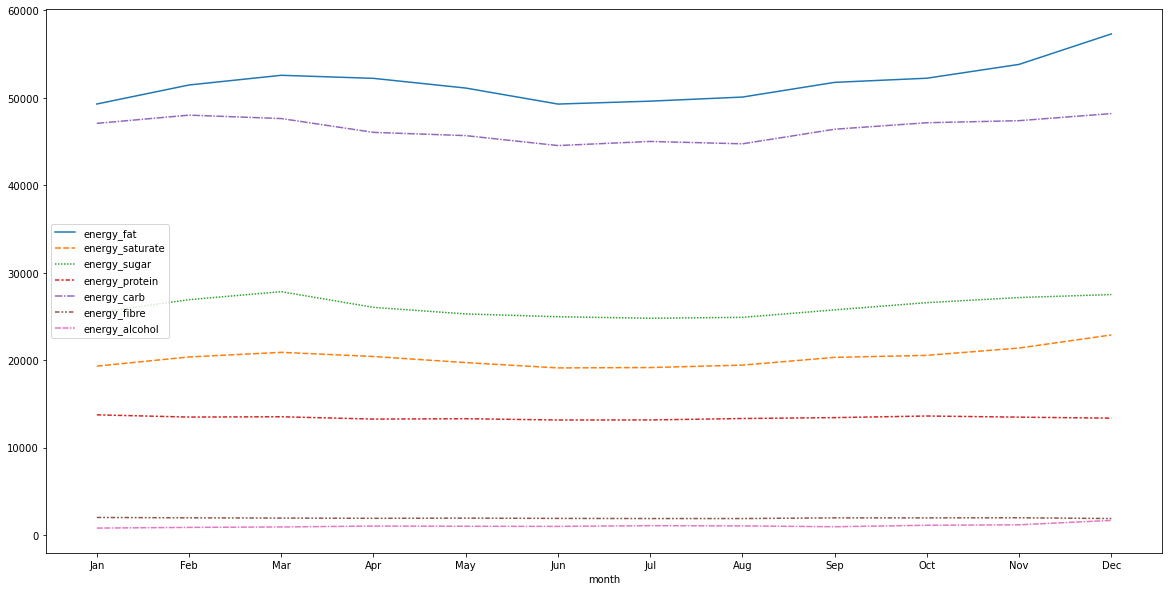

In [115]:
fig, ax = plt.subplots(figsize = (20,10))

g = sns.lineplot(data = osward_months.groupby(by = "month").sum()[nutrients], ax = ax)
plt.show()

#### Some Regression

In [116]:
log_model_interaction_variable = smf.ols(formula='ethnicity_bame_2011 ~ energy_fat + energy_saturate + energy_sugar + energy_protein + energy_carb + energy_fibre + energy_alcohol',data=lsoa_combined_year)
res = log_model_interaction_variable.fit()

# Print thes summary output provided by the library.
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     ethnicity_bame_2011   R-squared:                       0.481
Model:                             OLS   Adj. R-squared:                  0.480
Method:                  Least Squares   F-statistic:                     512.0
Date:                 Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                         14:15:33   Log-Likelihood:                -27322.
No. Observations:                 3874   AIC:                         5.466e+04
Df Residuals:                     3866   BIC:                         5.471e+04
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5176.1760    13

In [117]:
log_model_interaction_variable = smf.ols(formula='annual_median_income_2011 ~ energy_fat + energy_saturate + energy_sugar + energy_protein + energy_carb + energy_fibre + energy_alcohol',data=lsoa_combined_year)
res = log_model_interaction_variable.fit()

# Print thes summary output provided by the library.
print(res.summary())

                                OLS Regression Results                               
Dep. Variable:     annual_median_income_2011   R-squared:                       0.495
Model:                                   OLS   Adj. R-squared:                  0.494
Method:                        Least Squares   F-statistic:                     540.7
Date:                       Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                               14:15:34   Log-Likelihood:                -40266.
No. Observations:                       3874   AIC:                         8.055e+04
Df Residuals:                           3866   BIC:                         8.060e+04
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

#### Barplots for different interesting attributes

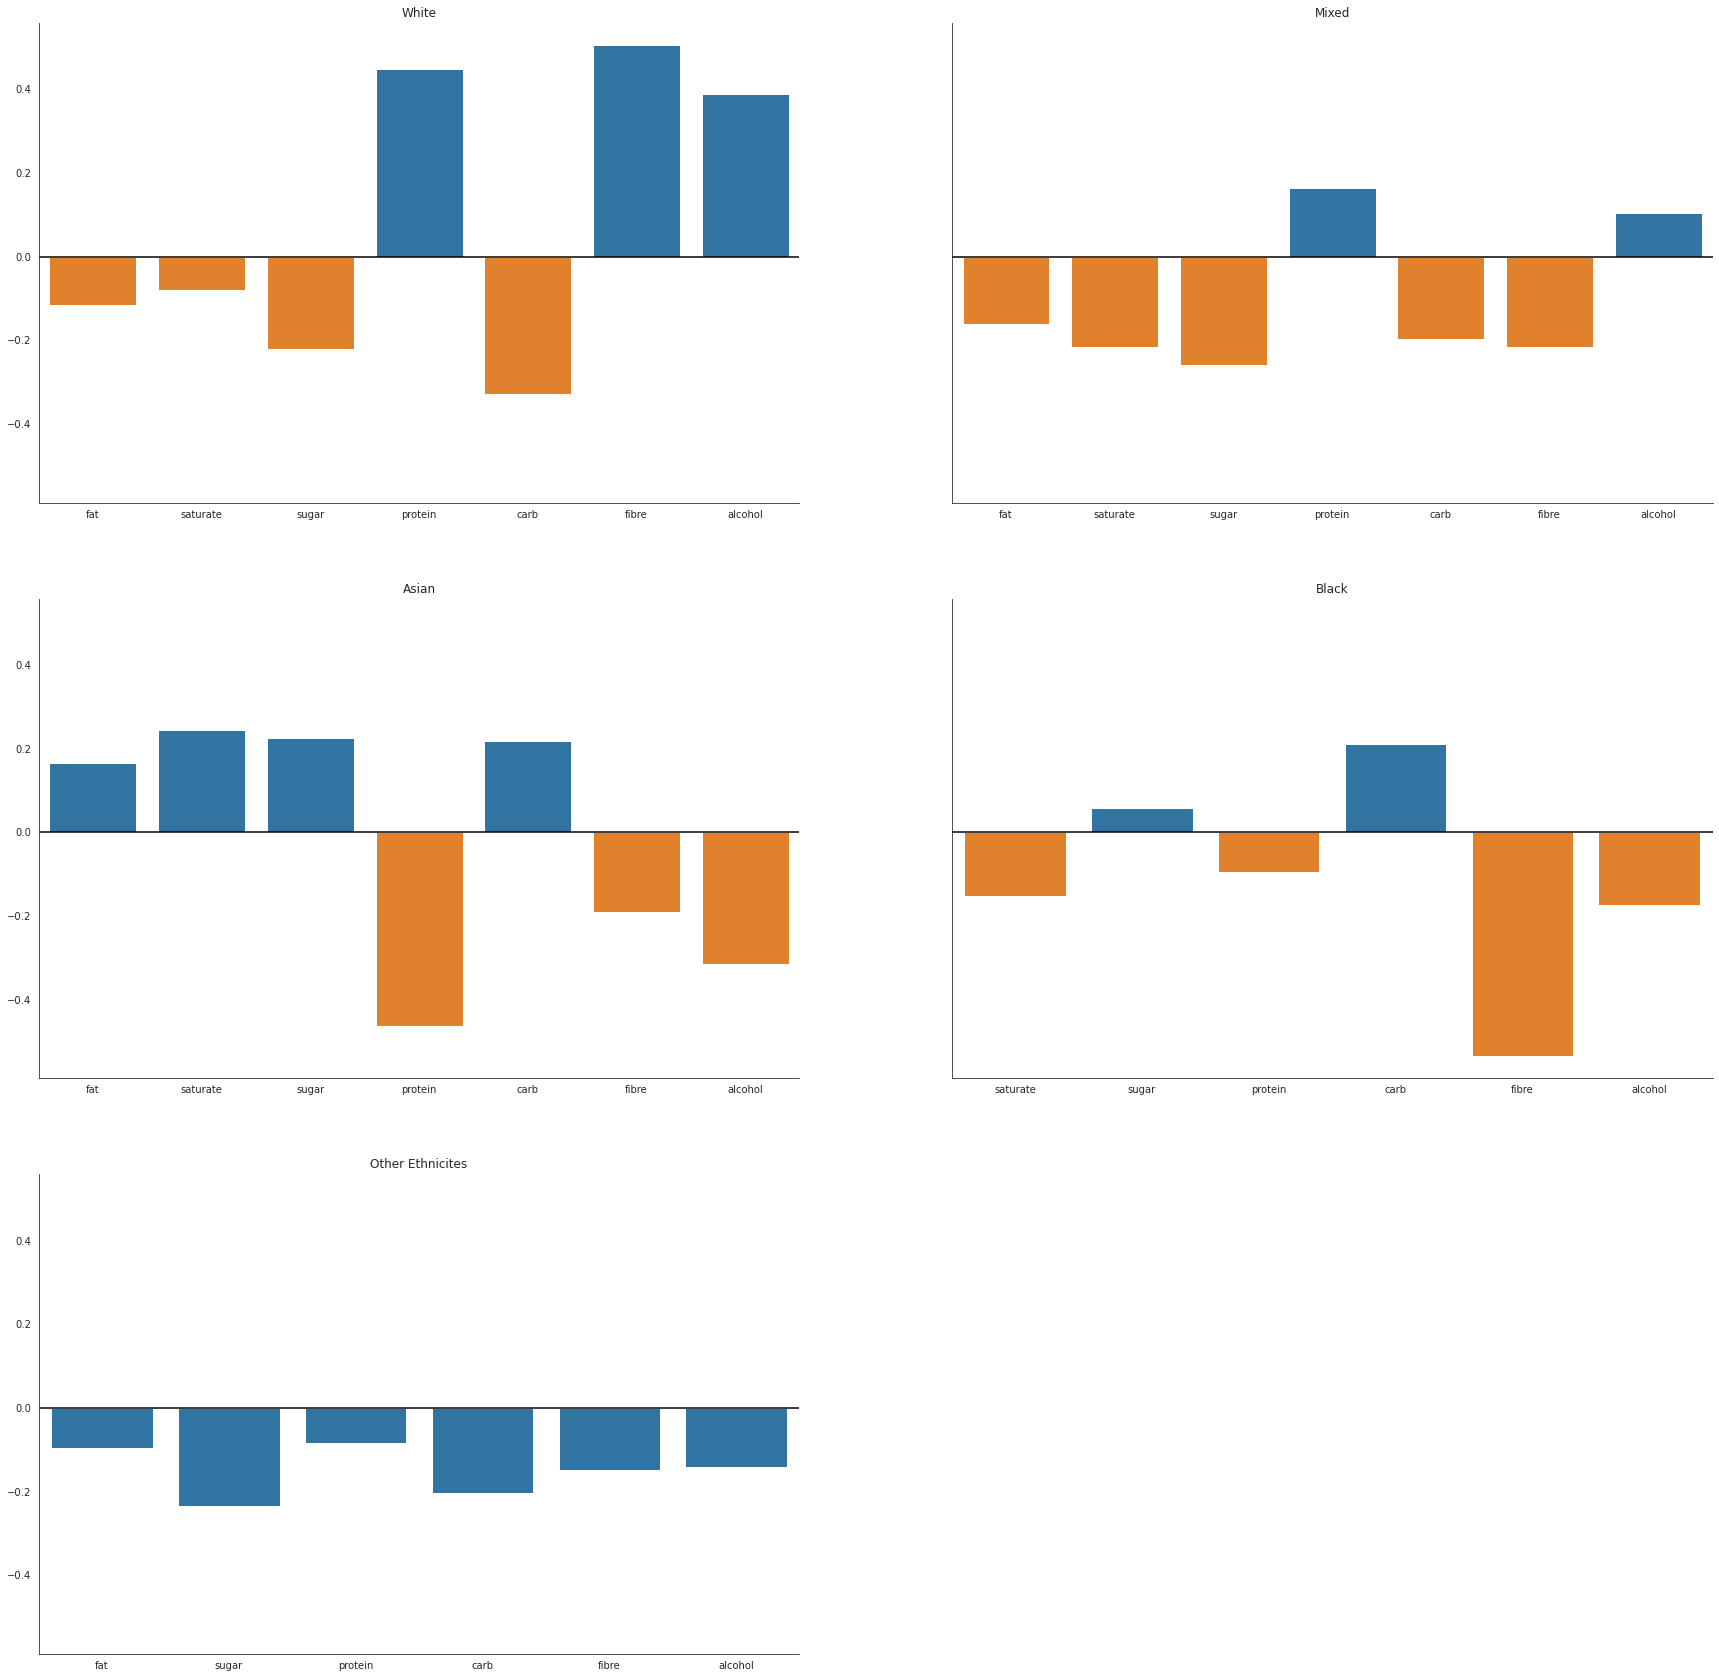

In [303]:
with sns.axes_style("white"): 

    f, axes = plt.subplots(3, 2, figsize=(30, 30), sharey = True)
    axes = axes.flatten()

    for ax, eth in zip(axes,ethnicities):
        correl = [(nutr, stats.spearmanr(a = lsoa_combined_year[eth], b = lsoa_combined_year[nutr]).correlation) for nutr in nutrients if stats.spearmanr(a = lsoa_combined_year[eth], b = lsoa_combined_year[nutr]).pvalue < 0.05]
        colors = [0 if c[1] >= 0 else 1 for c in correl]
        sns.barplot(x= [x[0].split("_")[1] for x in correl], y=[x[1] for x in correl], hue=colors, palette=sns.color_palette(), dodge=False, ax = ax)
        ax.axhline(0, ls='-', c = 'k')
        ax.get_legend().remove()
        ax.set_title(label_processor(eth))

    sns.despine(top = True, right = True)
    axes[-1].set_visible(False)

plt.show()

In [138]:
lsoa_combined_items = lsoa_combined_year[ethnicities + religions + nutrients + ["annual_median_income_2011"]].copy()
lsoa_combined_items.columns = [x.split("y_")[1].replace("_2011", "") for x in ethnicities] + ['Christian', 'Buddhist','Hindu','Jewish','Muslim','Sikh','No_religion','Other_religion']  + [x.split("_")[1] for x in  nutrients] + ["Median_Income"] 
 
# You could do this probably somewhat smarter 
# Encoding Data into a "Set" Dataset
for col in lsoa_combined_items.columns:
    lower  =  lsoa_combined_items[col].quantile(0.25)
    middle =  lsoa_combined_items[col].quantile(0.5)
    higher =  lsoa_combined_items[col].quantile(0.75)
    lsoa_combined_items[col + "_Low"] = lsoa_combined_items[col].apply(lambda x : x < lower)
    lsoa_combined_items[col + "_Low_to_Middle"] = lsoa_combined_items[col].apply(lambda x : x >= lower and x < middle)
    lsoa_combined_items[col + "_Middle_to_High"] = lsoa_combined_items[col].apply(lambda x :  x < higher and x > middle)
    lsoa_combined_items[col + "_High"] = lsoa_combined_items[col].apply(lambda x : x > higher )
    lsoa_combined_items = lsoa_combined_items.drop(col, axis = 1)
    

# Given the structure of the information, low support is indemic
frequent_itemsets = apriori(lsoa_combined_items, min_support = 0.05, use_colnames = True)

# Use Association Rules as an "explainable" Model
cleaned_names = [x.split("_")[1] for x in nutrients]
cleaned_names = [x + "_High" for x in cleaned_names] + [x + "_Low" for x in cleaned_names] + [x + "Low_to_Middle" for x in cleaned_names]+ [x + "Middle_to_High" for x in cleaned_names]
nutrient_sets = set(cleaned_names)

rules_association = arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.6)
rules_association[rules_association.apply(lambda x : True if x["antecedents"].issubset(nutrient_sets) and not x["consequents"].issubset(nutrient_sets) else False, axis = 1)].sort_values(by = "confidence", ascending = False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6617,"(carb_High, saturate_High, protein_Low)",(asian_High),0.065307,0.250129,0.053691,0.822134,3.286841,0.037356,4.215941
8089,"(carb_High, saturate_High, protein_Low)",(Other_religion_Low),0.065307,0.248064,0.053433,0.818182,3.298269,0.037233,4.135648
6605,"(carb_High, fat_High, protein_Low)",(asian_High),0.064533,0.250129,0.052659,0.816000,3.262316,0.036517,4.075386
8077,"(carb_High, fat_High, protein_Low)",(Other_religion_Low),0.064533,0.248064,0.051884,0.804000,3.241099,0.035876,3.836408
16687,"(carb_High, saturate_High, protein_Low)","(Other_religion_Low, asian_High)",0.065307,0.175271,0.052401,0.802372,4.577890,0.040954,4.173129
6582,"(fat_High, protein_Low, saturate_High)",(asian_High),0.077697,0.250129,0.061951,0.797342,3.187723,0.042517,3.700183
16647,"(carb_High, fat_High, protein_Low)","(Other_religion_Low, asian_High)",0.064533,0.175271,0.051110,0.792000,4.518716,0.039799,3.965043
16708,"(saturate_High, protein_Low, sugar_High, fat_H...",(asian_High),0.064791,0.250129,0.050852,0.784861,3.137822,0.034646,3.485511
4053,"(carb_High, fat_High, protein_Low)",(white_Low),0.064533,0.250129,0.050336,0.780000,3.118390,0.034194,3.408504
7547,"(carb_High, fat_High, protein_Low)",(bame_High),0.064533,0.250129,0.050336,0.780000,3.118390,0.034194,3.408504


In [141]:
X = lsoa_combined_year[nutrients]
y = lsoa_combined_year['annual_median_income_2011']
n_estimators =  [75,100,200,250]
max_features = ["auto", "sqrt"]

    
for x in tqdm(it.product(n_estimators,max_features)): 
    
    print("\n", x)
    random_forest = RandomForestRegressor(n_estimators = x[0], max_features = x[1])
    print(cross_val_score(estimator = random_forest, X = X, y = y, cv = 20, n_jobs = -1).mean())
    

0it [00:00, ?it/s]


 (75, 'auto')


1it [00:13, 13.27s/it]

0.4960410298240815

 (75, 'sqrt')


2it [00:17, 10.52s/it]

0.5020071041133997

 (100, 'auto')


3it [00:29, 11.07s/it]

0.5014033004082666

 (100, 'sqrt')


4it [00:35,  9.52s/it]

0.5023079808166456

 (200, 'auto')


5it [01:00, 14.08s/it]

0.5021904448474477

 (200, 'sqrt')


6it [01:12, 13.37s/it]

0.5064588352405371

 (250, 'auto')


7it [01:43, 18.69s/it]

0.504163354145805

 (250, 'sqrt')


8it [01:56, 14.55s/it]

0.5077504863941674


In [142]:
X = lsoa_combined_year[nutrients]
y = lsoa_combined_year['annual_median_income_2011']
n_estimators = [20,50,100,200,250]
learning_rate = [0.1, 0.05, 0.01]

for x in tqdm(it.product(n_estimators, learning_rate)): 
    
    print("\n", x)
    lin_regression = LinearRegression()
    ada = AdaBoostRegressor(base_estimator = lin_regression,  n_estimators = x[0], loss = "linear", learning_rate = x[1]) 
    print(cross_val_score(estimator = ada, X = X, y = y, cv = 20, n_jobs = -1).mean())
    

0it [00:00, ?it/s]


 (20, 0.1)


1it [00:00,  2.09it/s]

0.37814884330365045

 (20, 0.05)


2it [00:00,  2.26it/s]

0.3943079425261799

 (20, 0.01)


3it [00:01,  2.36it/s]

0.4122091000066129

 (50, 0.1)


4it [00:02,  1.88it/s]

0.31791153981907183

 (50, 0.05)


5it [00:02,  1.64it/s]

0.36283966683302676

 (50, 0.01)


6it [00:03,  1.50it/s]

0.4076041144343797

 (100, 0.1)


7it [00:04,  1.16it/s]

0.29729192133875904

 (100, 0.05)


8it [00:06,  1.06s/it]

0.3186758309713661

 (100, 0.01)


9it [00:07,  1.16s/it]

0.3941838527734772

 (200, 0.1)


10it [00:09,  1.24s/it]

0.29155396812052836

 (200, 0.05)


11it [00:12,  1.74s/it]

0.2937233059191962

 (200, 0.01)


12it [00:15,  2.11s/it]

0.37456125395720885

 (250, 0.1)


13it [00:16,  1.96s/it]

0.2955307496021763

 (250, 0.05)


14it [00:19,  2.16s/it]

0.29468385614316683

 (250, 0.01)


15it [00:23,  1.54s/it]

0.3617542939405937


In [57]:
# Shuffle Split 
x_train, x_test , y_train, y_test = train_test_split(lsoa_combined_year[nutrients], lsoa_combined_year['annual_median_income_2011'], random_state=0) 
# The Ada Pipeline 
ada_pipeline = pipeline_factory(scaler = StandardScaler(), model = AdaBoostRegressor(base_estimator = LinearRegression()), x_train = x_train, y_train = y_train)

ada_pipeline.score(x_test, y_test)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.1s


0.29422327058446573

In [58]:
# Shuffle Split 
x_train, x_test , y_train, y_test = train_test_split(msoa_combined_year[nutrients], msoa_combined_year['annual_median_income_2011'], random_state=0) 
# The Ada Pipeline 
ada_pipeline = pipeline_factory(scaler = StandardScaler(), model = AdaBoostRegressor(base_estimator = LinearRegression()), x_train = x_train, y_train = y_train)

ada_pipeline.score(x_test, y_test)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s


0.5916198554571601

In [59]:

X = msoa_combined_year[nutrients]
y = msoa_combined_year['annual_median_income_2011']

n_estimators =  [75,100,200,250]
max_features = ["auto", "sqrt"]

for x in tqdm(it.product(n_estimators,max_features)): 
    print("\n", x)
    random_forest = RandomForestRegressor(n_estimators = x[0], max_features = x[1])
    print(cross_val_score(estimator = random_forest, X = X, y = y, cv = 20, n_jobs = -1).mean())
    

0it [00:00, ?it/s]


 (75, 'auto')


1it [00:02,  2.14s/it]

0.5568301990827698

 (75, 'sqrt')


2it [00:03,  1.92s/it]

0.5714009928283768

 (100, 'auto')


3it [00:06,  2.21s/it]

0.559054316140492

 (100, 'sqrt')


4it [00:08,  2.07s/it]

0.5638348759583334

 (200, 'auto')


5it [00:13,  3.18s/it]

0.560111011265736

 (200, 'sqrt')


6it [00:17,  3.26s/it]

0.5688248539522524

 (250, 'auto')


7it [00:24,  4.37s/it]

0.5631094777884649

 (250, 'sqrt')


8it [00:28,  3.60s/it]

0.5665135750284136


In [60]:
X = msoa_combined_year[nutrients]
y = msoa_combined_year['annual_median_income_2011']
n_estimators = [20,50,100,200,250]
learning_rate = [0.1, 0.05, 0.01]

for x in tqdm(it.product(n_estimators, learning_rate)): 
    print("\n", x)
    lin_regression = LinearRegression()
    ada = AdaBoostRegressor(base_estimator = lin_regression,  n_estimators = x[0], loss = "linear", learning_rate = x[1]) 
  
    print(cross_val_score(estimator = ada, X = X, y = y, cv = 20, n_jobs = -1).mean())
    

0it [00:00, ?it/s]


 (20, 0.1)


1it [00:00,  4.39it/s]

0.4919242570449689

 (20, 0.05)


2it [00:00,  4.13it/s]

0.502761209929587

 (20, 0.01)


3it [00:00,  4.13it/s]

0.5001194908631519

 (50, 0.1)


4it [00:01,  3.15it/s]

0.4583233179491858

 (50, 0.05)


5it [00:01,  2.78it/s]

0.4864653692802382

 (50, 0.01)


6it [00:02,  2.60it/s]

0.5009370908515549

 (100, 0.1)


7it [00:02,  2.15it/s]

0.4461290076599127

 (100, 0.05)


8it [00:03,  1.76it/s]

0.4623316326291057

 (100, 0.01)


9it [00:04,  1.55it/s]

0.5002953946928905

 (200, 0.1)


10it [00:05,  1.55it/s]

0.44443801855386084

 (200, 0.05)


11it [00:06,  1.28it/s]

0.446089458994253

 (200, 0.01)


12it [00:07,  1.01s/it]

0.4913740410808793

 (250, 0.1)


13it [00:08,  1.07it/s]

0.4454097249277629

 (250, 0.05)


14it [00:09,  1.02s/it]

0.4500935183967944

 (250, 0.01)


15it [00:11,  1.30it/s]

0.48747917719551986


In [304]:
msoa_combined_items = msoa_combined_year[ethnicities + religions + nutrients + ["annual_median_income_2011"]].copy()
msoa_combined_items.columns = [x.split("y_")[1].replace("_2011", "") for x in ethnicities] + ['Christian', 'Buddhist','Hindu','Jewish','Muslim','Sikh','No_religion','Other_religion']  + [x.split("_")[1] for x in  nutrients] + ["Median_Income"] 
 
# You could do this probably somewhat smarter 
# Encoding Data into a "Set" Dataset

for col in msoa_combined_items.columns:
    lower  =  msoa_combined_items[col].quantile(0.25)
    middle =  msoa_combined_items[col].quantile(0.5)
    higher =  msoa_combined_items[col].quantile(0.75)
    msoa_combined_items[col + "_Low"] = msoa_combined_items[col].apply(lambda x : x < lower)
    msoa_combined_items[col + "_Low_to_Middle"] = msoa_combined_items[col].apply(lambda x : x >= lower and x < middle)
    msoa_combined_items[col + "_Middle_to_High"] = msoa_combined_items[col].apply(lambda x :  x < higher and x > middle)
    msoa_combined_items[col + "_High"] = msoa_combined_items[col].apply(lambda x : x > higher)
    msoa_combined_items = msoa_combined_items.drop(col, axis = 1)
    

# Given the structure of the information, low support is indemic
frequent_itemsets = apriori(msoa_combined_items, min_support = 0.05, use_colnames = True)

# Use Association Rules as an "explainable" Model
cleaned_names = [x.split("_")[1] for x in nutrients]
cleaned_names = [x + "_High" for x in cleaned_names] + [x + "_Low" for x in cleaned_names] + [x + "Low_to_Middle" for x in cleaned_names]+ [x + "Middle_to_High" for x in cleaned_names]
nutrient_sets = set(cleaned_names)

rules_association = arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.6)
rules_association[rules_association.apply(lambda x : True if x["antecedents"].issubset(nutrient_sets) and not x["consequents"].issubset(nutrient_sets) else False, axis = 1)].sort_values(by = "confidence", ascending = False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
13939,"(fibre_High, carb_Low, alcohol_High)",(Median_Income_High),0.055305,0.250564,0.054176,0.979592,3.909542,0.040319,36.722348
3226,"(fibre_High, alcohol_High)",(Median_Income_High),0.069977,0.250564,0.065463,0.935484,3.733508,0.047929,11.616253
10464,"(saturate_High, protein_Low, alcohol_Low)",(asian_High),0.060948,0.248307,0.055305,0.907407,3.654377,0.040171,8.118284
36045,"(saturate_High, alcohol_Low, protein_Low, fat_...",(asian_High),0.056433,0.248307,0.050790,0.900000,3.624545,0.036777,7.516930
10442,"(fat_High, protein_Low, alcohol_Low)",(asian_High),0.062077,0.248307,0.055305,0.890909,3.587934,0.039891,6.890519
10482,"(carb_High, protein_Low, alcohol_Low)",(asian_High),0.065463,0.248307,0.057562,0.879310,3.541223,0.041307,6.228313
10456,"(carb_High, saturate_High, protein_Low)",(asian_High),0.072235,0.248307,0.063205,0.875000,3.523864,0.045269,6.013544
12412,"(saturate_High, protein_Low, alcohol_Low)",(bame_High),0.060948,0.250564,0.053047,0.870370,3.473640,0.037776,5.781361
5734,"(saturate_High, protein_Low, alcohol_Low)",(white_Low),0.060948,0.250564,0.053047,0.870370,3.473640,0.037776,5.781361
13801,"(saturate_High, protein_Low, alcohol_Low)",(Other_religion_Low),0.060948,0.250564,0.053047,0.870370,3.473640,0.037776,5.781361


In [146]:
log_model_interaction_variable = smf.ols(formula='ethnicity_bame_2011 ~ energy_fat + energy_saturate + energy_sugar + energy_protein + energy_carb + energy_fibre + energy_alcohol',data=msoa_combined_year)
res = log_model_interaction_variable.fit()

# Print thes summary output provided by the library.
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     ethnicity_bame_2011   R-squared:                       0.557
Model:                             OLS   Adj. R-squared:                  0.554
Method:                  Least Squares   F-statistic:                     158.0
Date:                 Fri, 27 Nov 2020   Prob (F-statistic):          1.12e-150
Time:                         14:31:29   Log-Likelihood:                -7573.7
No. Observations:                  886   AIC:                         1.516e+04
Df Residuals:                      878   BIC:                         1.520e+04
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.512e+04   172

In [147]:
log_model_interaction_variable = smf.ols(formula='annual_median_income_2011 ~ energy_fat + energy_saturate + energy_sugar + energy_protein + energy_carb + energy_fibre + energy_alcohol',data=msoa_combined_year)
res = log_model_interaction_variable.fit()

# Print thes summary output provided by the library.
print(res.summary())

                                OLS Regression Results                               
Dep. Variable:     annual_median_income_2011   R-squared:                       0.604
Model:                                   OLS   Adj. R-squared:                  0.601
Method:                        Least Squares   F-statistic:                     191.6
Date:                       Fri, 27 Nov 2020   Prob (F-statistic):          5.99e-172
Time:                               14:31:29   Log-Likelihood:                -9077.5
No. Observations:                        886   AIC:                         1.817e+04
Df Residuals:                            878   BIC:                         1.821e+04
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

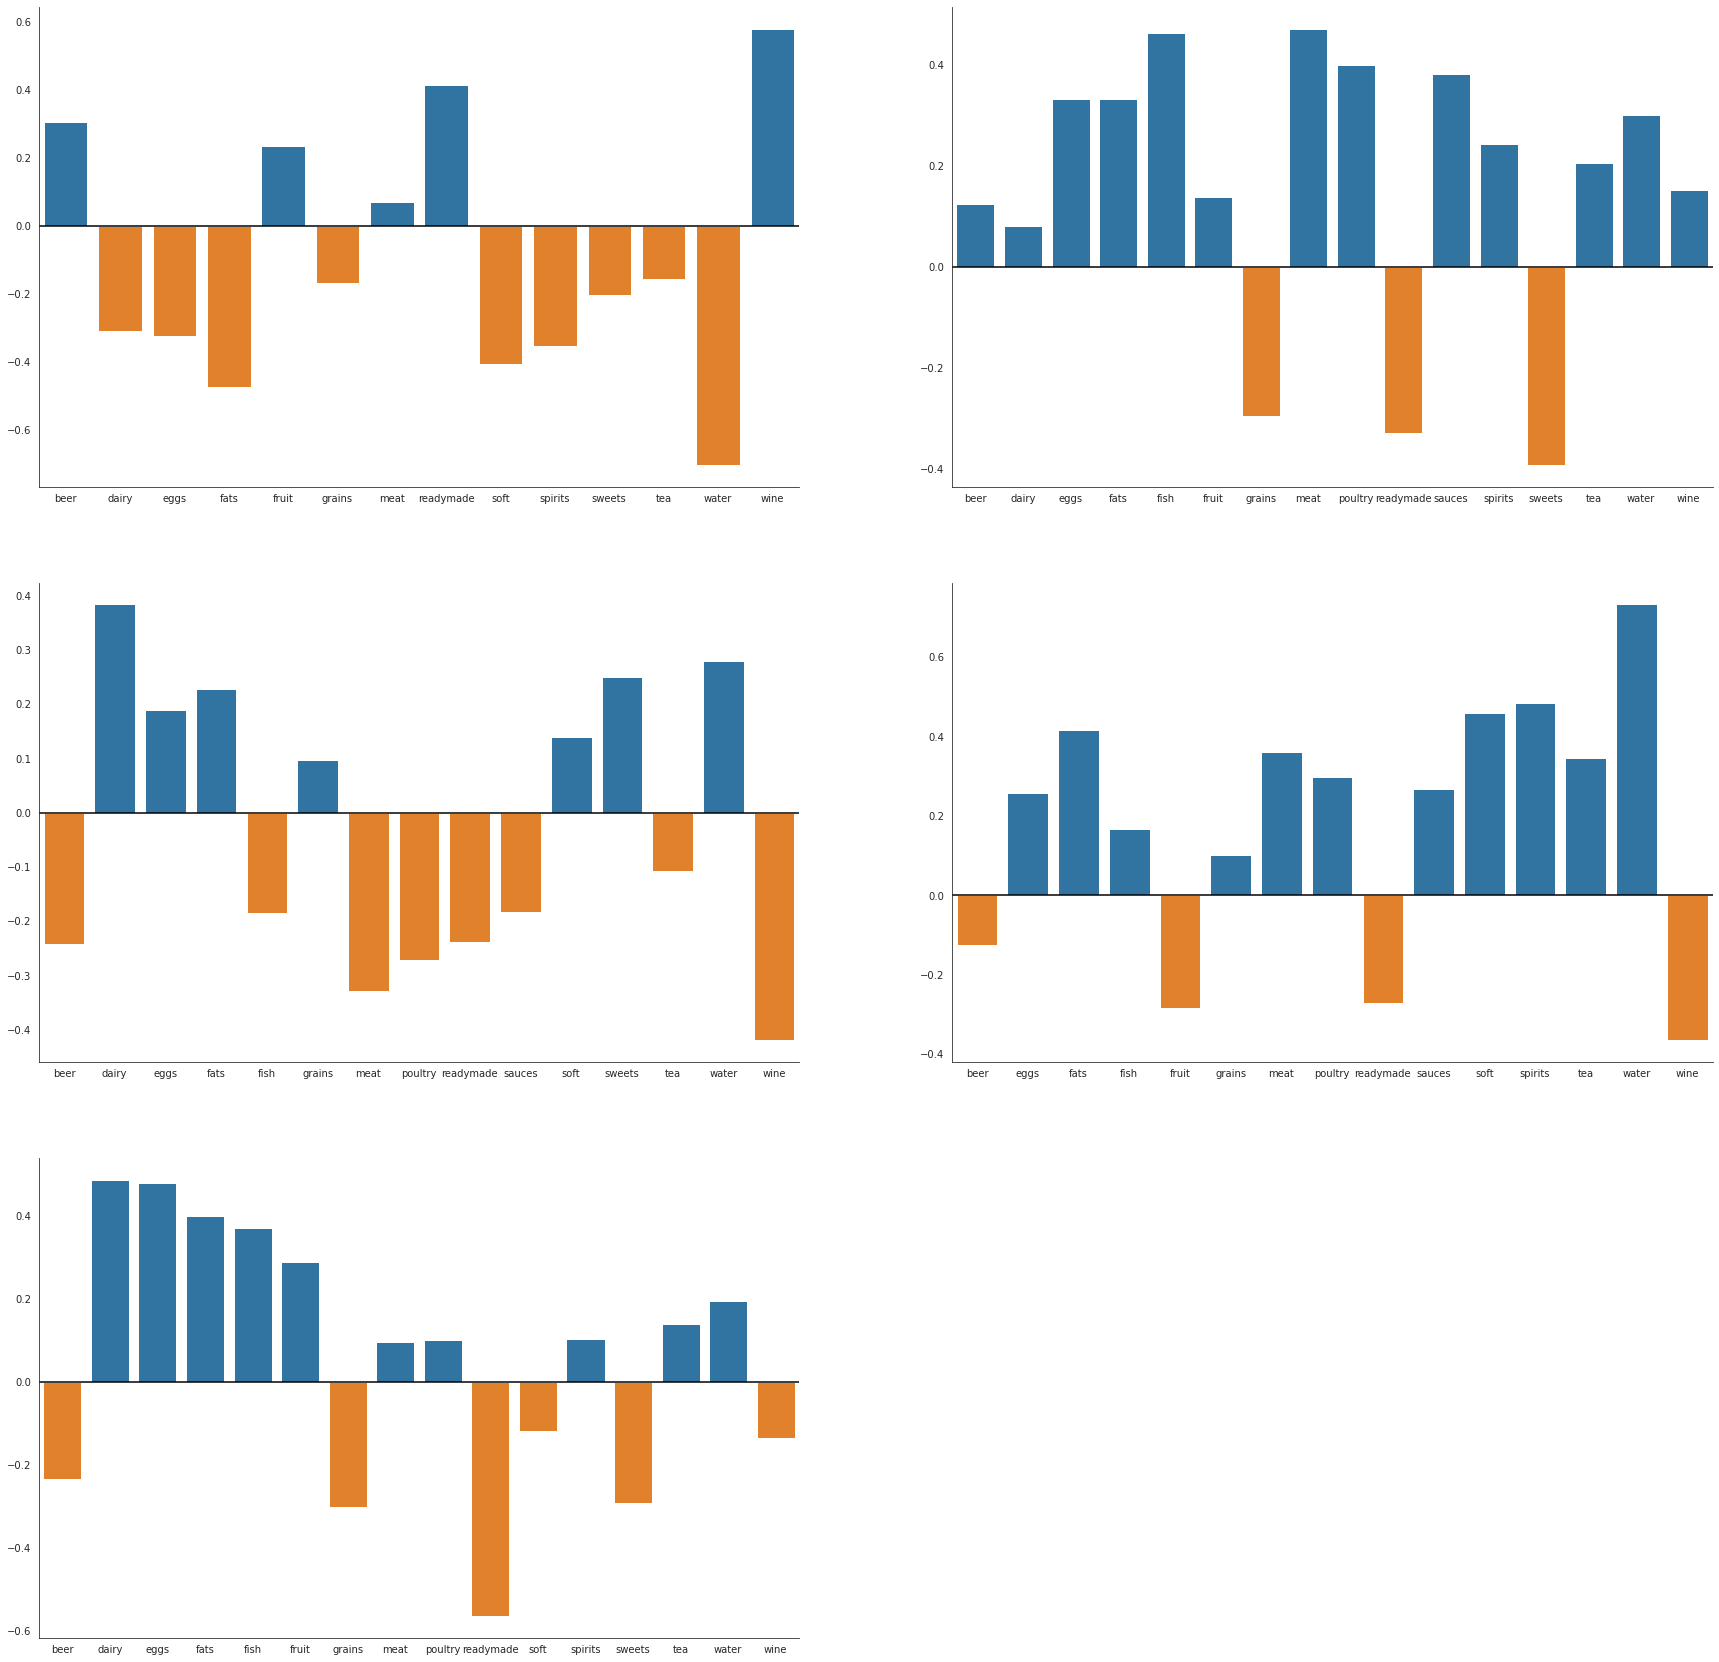

In [148]:
with sns.axes_style("white"): 

    f, axes = plt.subplots(3, 2, figsize=(30, 30))
    axes = axes.flatten()

    for ax, eth in zip(axes,ethnicities):
        correl = [(nutr, stats.spearmanr(a = msoa_combined_year[eth], b = msoa_combined_year[nutr]).correlation) for nutr in products if stats.spearmanr(a = msoa_combined_year[eth], b = msoa_combined_year[nutr]).pvalue < 0.05]
        colors = [0 if c[1] >= 0 else 1 for c in correl]
        sns.barplot(x= [x[0].split("_")[1] for x in correl], y=[x[1] for x in correl], hue=colors, palette=sns.color_palette(), dodge=False, ax = ax)
        ax.axhline(0, ls='-', c = 'k')
        ax.get_legend().remove()
        ax.set_title(eth.split("perc")[0].replace("_", " "))

    sns.despine(top = True, right = True)
    axes[-1].set_visible(False)

plt.show()



In [154]:
msoa_combined_items = msoa_combined_year[ethnicities + religions + products + ["annual_median_income_2011"]].copy()
msoa_combined_items.columns = [x.split("y_")[1].replace("_2011", "") for x in ethnicities] + ['Christian', 'Buddhist','Hindu','Jewish','Muslim','Sikh','No_religion','Other_religion']  + [x.split("_")[1] for x in products] + ["Median_Income"] 
 
# You could do this probably somewhat smarter 
# Encoding Data into a "Set" Dataset

for col in msoa_combined_items.columns:
    lower  =  msoa_combined_items[col].quantile(0.25)
    middle =  msoa_combined_items[col].quantile(0.5)
    higher =  msoa_combined_items[col].quantile(0.75)
    msoa_combined_items[col + "_Low"] = msoa_combined_items[col].apply(lambda x : x < lower)
    msoa_combined_items[col + "_Low_to_Middle"] = msoa_combined_items[col].apply(lambda x : x >= lower and x < middle)
    msoa_combined_items[col + "_Middle_to_High"] = msoa_combined_items[col].apply(lambda x :  x < higher and x > middle)
    msoa_combined_items[col + "_High"] = msoa_combined_items[col].apply(lambda x : x > higher)
    msoa_combined_items = msoa_combined_items.drop(col, axis = 1)
    

# Given the structure of the information, low support is indemic
frequent_itemsets = apriori(msoa_combined_items, min_support = 0.05, use_colnames = True)

# Use Association Rules as an "explainable" Model
cleaned_names = [x.split("_")[1] for x in products]
cleaned_names = [x + "_High" for x in cleaned_names] + [x + "_Low" for x in cleaned_names] + [x + "Low_to_Middle" for x in cleaned_names]+ [x + "Middle_to_High" for x in cleaned_names]
nutrient_sets = set(cleaned_names)

rules_association = arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.6)
rules_association[rules_association.apply(lambda x : True if x["antecedents"].issubset(nutrient_sets) and not x["consequents"].issubset(nutrient_sets) else False, axis = 1)].sort_values(by = "confidence", ascending = False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
129296,"(soft_Low, wine_High, tea_Low, water_Low)",(Median_Income_High),0.054176,0.250564,0.053047,0.979167,3.907845,0.039473,35.972912
39257,"(soft_Low, wine_High, tea_Low)",(Median_Income_High),0.059819,0.250564,0.057562,0.962264,3.840388,0.042573,19.860045
32128,"(dairy_High, poultry_Low, meat_Low)",(Christian_Low),0.055305,0.250564,0.053047,0.959184,3.828093,0.039190,18.361174
324742,"(soft_Low, wine_High, grains_Low, water_Low, s...",(Median_Income_High),0.063205,0.250564,0.059819,0.946429,3.777188,0.043982,13.989466
626067,"(soft_Low, wine_High, grains_Low, water_Low, s...",(Median_Income_High),0.063205,0.250564,0.059819,0.946429,3.777188,0.043982,13.989466
626074,"(soft_Low, wine_High, grains_Low, water_Low, s...","(Median_Income_High, fruit_High)",0.063205,0.147856,0.059819,0.946429,6.401036,0.050474,15.906697
39251,"(soft_Low, tea_Low, water_Low)",(Median_Income_High),0.062077,0.250564,0.058691,0.945455,3.773301,0.043137,13.739654
324706,"(soft_Low, wine_High, water_Low, sweets_Low, f...",(Median_Income_High),0.075621,0.250564,0.071106,0.940299,3.752723,0.052158,12.553047
324712,"(soft_Low, sweets_Low, wine_High, water_Low)","(Median_Income_High, fruit_High)",0.075621,0.147856,0.071106,0.940299,6.359576,0.059925,14.273420
129283,"(soft_Low, sweets_Low, wine_High, water_Low)",(Median_Income_High),0.075621,0.250564,0.071106,0.940299,3.752723,0.052158,12.553047


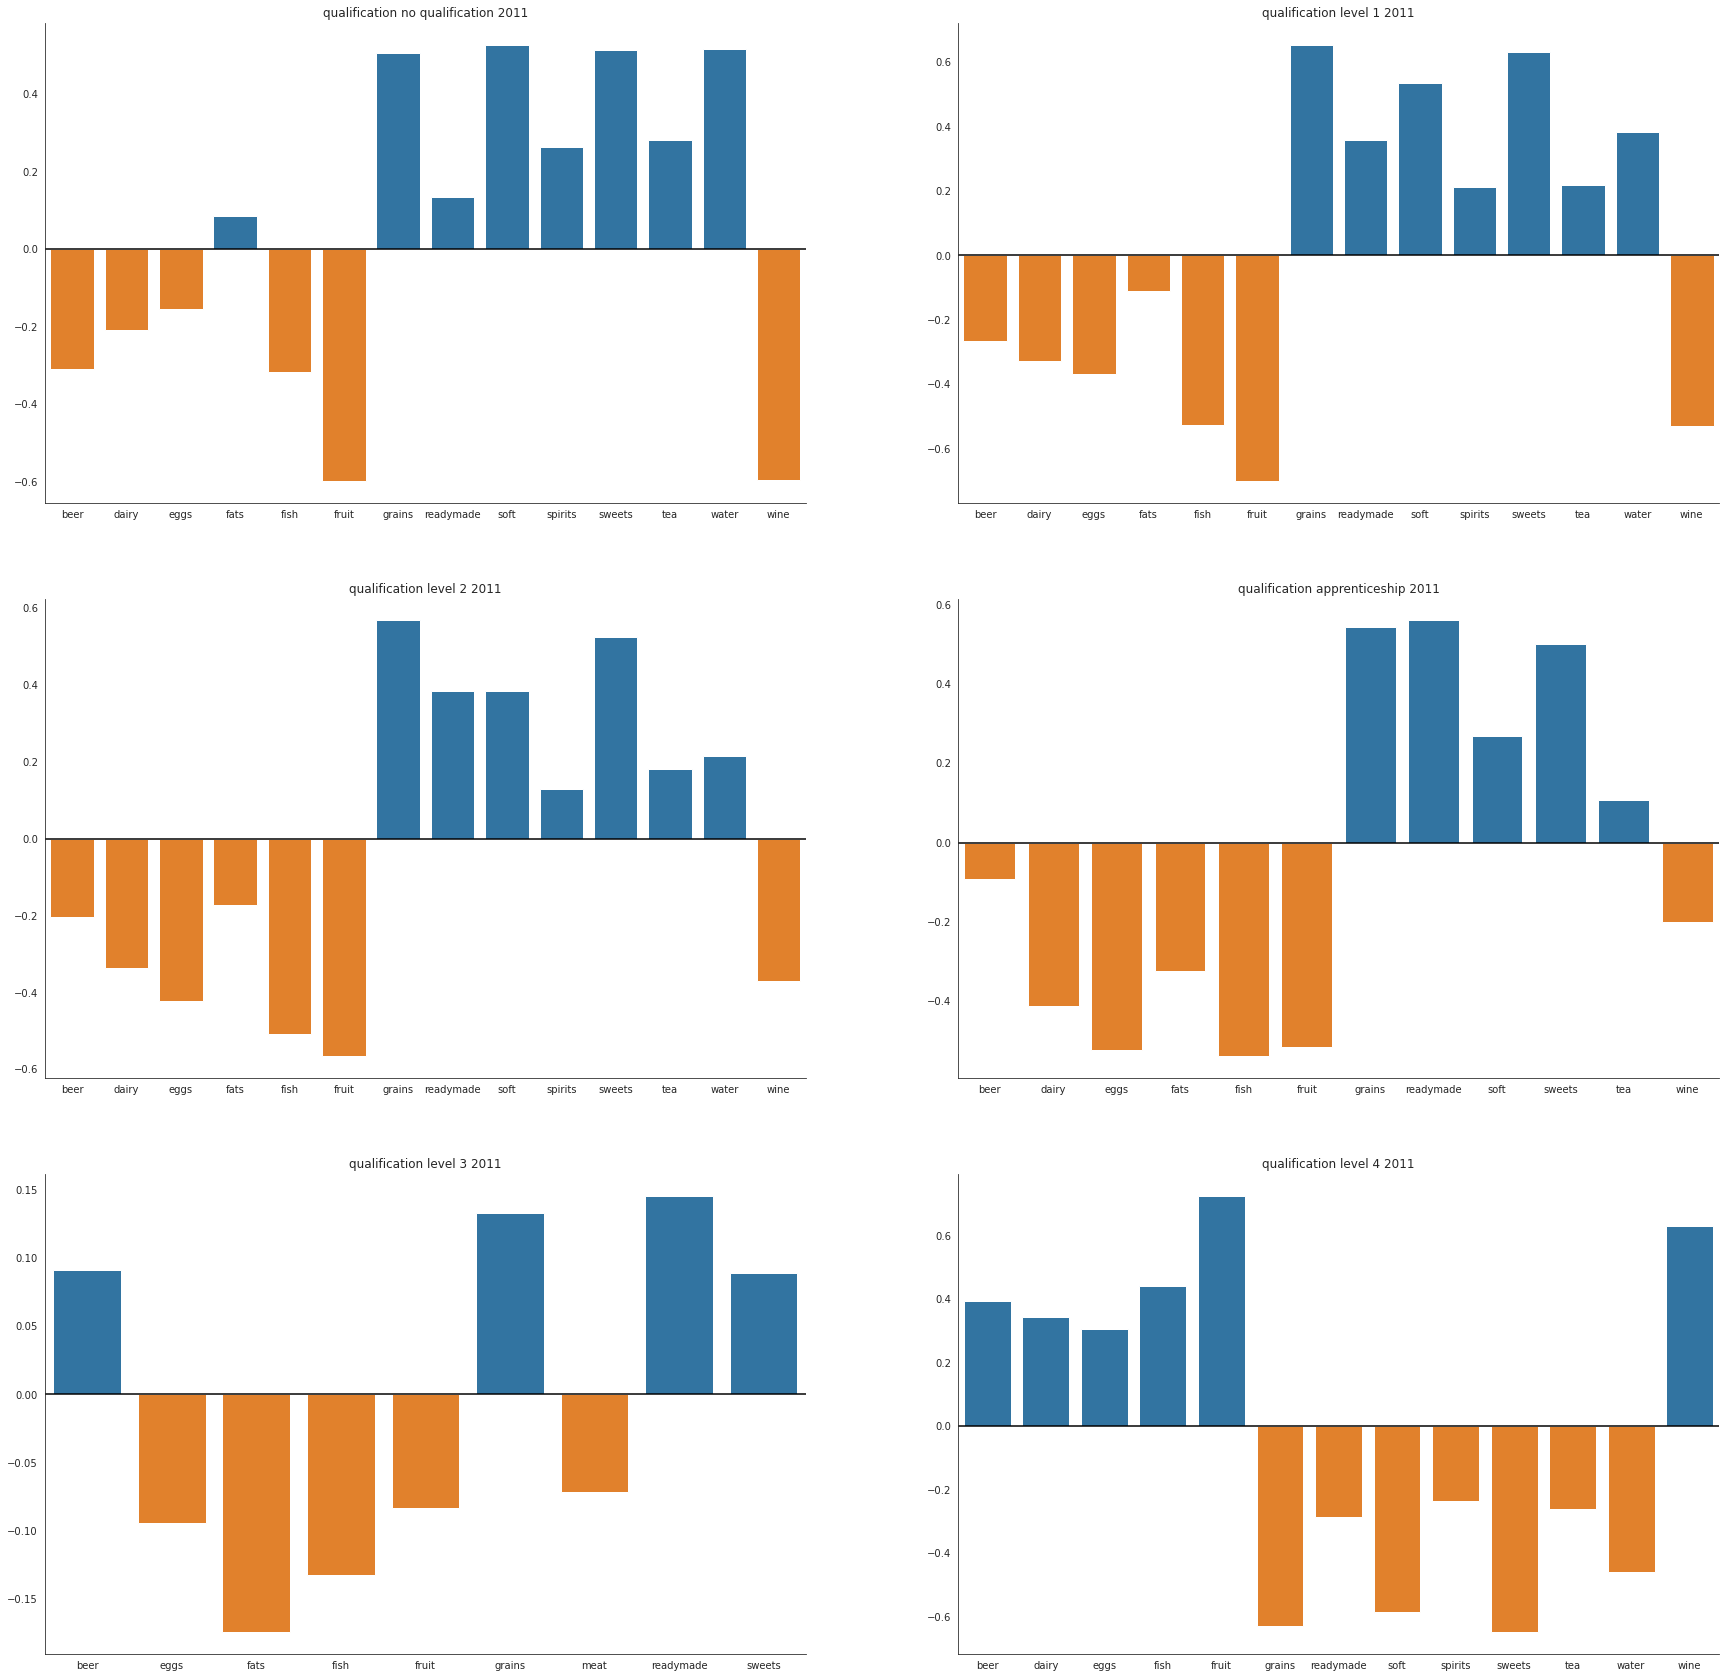

In [160]:
with sns.axes_style("white"): 

    f, axes = plt.subplots(3, 2, figsize=(30, 30))
    axes = axes.flatten()

    for ax, eth in zip(axes,education):
        correl = [(nutr, stats.spearmanr(a = msoa_combined_year[eth], b = msoa_combined_year[nutr]).correlation) for nutr in products if stats.spearmanr(a = msoa_combined_year[eth], b = msoa_combined_year[nutr]).pvalue < 0.05]
        colors = [0 if c[1] >= 0 else 1 for c in correl]
        sns.barplot(x= [x[0].split("_")[1] for x in correl], y=[x[1] for x in correl], hue=colors, palette=sns.color_palette(), dodge=False, ax = ax)
        ax.axhline(0, ls='-', c = 'k')
        ax.get_legend().remove()
        ax.set_title(eth.split("perc")[0].replace("_", " "))

    sns.despine(top = True, right = True)

plt.show()

In [165]:
msoa_combined_items = msoa_combined_year[ethnicities + products + education + ["annual_median_income_2011"]].copy()
msoa_combined_items.columns = [x.split("y_")[1].replace("_2011", "") for x in ethnicities] + [x.split("_")[1] for x in products] + [x.replace("qualification_", "", 1).replace("_2011", "") for x in education]  + ["Median_Income"] 
 
# You could do this probably somewhat smarter 
# Encoding Data into a "Set" Dataset

for col in msoa_combined_items.columns:
    lower  =  msoa_combined_items[col].quantile(0.25)
    middle =  msoa_combined_items[col].quantile(0.5)
    higher =  msoa_combined_items[col].quantile(0.75)
    msoa_combined_items[col + "_Low"] = msoa_combined_items[col].apply(lambda x : x < lower)
    msoa_combined_items[col + "_Low_to_Middle"] = msoa_combined_items[col].apply(lambda x : x >= lower and x < middle)
    msoa_combined_items[col + "_Middle_to_High"] = msoa_combined_items[col].apply(lambda x :  x < higher and x > middle)
    msoa_combined_items[col + "_High"] = msoa_combined_items[col].apply(lambda x : x > higher)
    msoa_combined_items = msoa_combined_items.drop(col, axis = 1)
    

print("Computing Frequent Itemset ...")
# Given the structure of the information, low support is indemic
frequent_itemsets = apriori(msoa_combined_items, min_support = 0.1, use_colnames = True)



# Use Association Rules as an "explainable" Model
cleaned_names = [x.split("_")[1] for x in products]
cleaned_names = [x + "_High" for x in cleaned_names] + [x + "_Low" for x in cleaned_names] + [x + "Low_to_Middle" for x in cleaned_names]+ [x + "Middle_to_High" for x in cleaned_names]
nutrient_sets = set(cleaned_names)
print("Computing Association Rules ...")
rules_association = arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.6)
print("Cleaning Rule Set for desiered Rules ...")
rules_association[rules_association.apply(lambda x : True if x["antecedents"].issubset(nutrient_sets) and not x["consequents"].issubset(nutrient_sets) else False, axis = 1)].sort_values(by = "confidence", ascending = False).head(20)

Computing Frequent Itemset ...
Computing Association Rules ...
Cleaning Rule Set for desiered Rules ...


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1293,"(sweets_Low, water_Low)",(level_1_Low),0.115124,0.250564,0.103837,0.901961,3.599717,0.074991,7.644244
2694,"(sweets_Low, fruit_High, water_Low)",(level_1_Low),0.112867,0.250564,0.101580,0.900000,3.591892,0.073300,7.494357
3026,"(soft_Low, wine_High, water_Low)",(Median_Income_High),0.116253,0.250564,0.103837,0.893204,3.564769,0.074709,7.017443
2697,"(sweets_Low, water_Low)","(level_1_Low, fruit_High)",0.115124,0.172686,0.101580,0.882353,5.109573,0.081700,7.032167
1289,"(sweets_Low, water_Low)",(no_qualification_Low),0.115124,0.250564,0.101580,0.882353,3.521463,0.072734,6.370203
2515,"(grains_Low, fruit_High, water_Low)",(no_qualification_Low),0.116253,0.250564,0.101580,0.873786,3.487274,0.072451,5.937836
2524,"(grains_Low, fruit_High, water_Low)",(level_1_Low),0.116253,0.250564,0.101580,0.873786,3.487274,0.072451,5.937836
2911,"(grains_Low, soft_Low, water_Low)",(Median_Income_High),0.119639,0.250564,0.101580,0.849057,3.388577,0.071603,4.965011
1027,"(fruit_High, wine_High)",(level_1_Low),0.130926,0.250564,0.110609,0.844828,3.371699,0.077804,4.829697
2618,"(soft_Low, fruit_High, water_Low)",(no_qualification_Low),0.128668,0.250564,0.108352,0.842105,3.360835,0.076112,4.746426


In [166]:
msoa_combined_items = msoa_combined_year[ethnicities + nutrients + education + ["annual_median_income_2011"]].copy()
msoa_combined_items.columns = [x.split("y_")[1].replace("_2011", "") for x in ethnicities] + [x.split("_")[1] for x in nutrients] + [x.replace("qualification_", "", 1).replace("_2011", "") for x in education] + ["Median_Income"] 
 
# You could do this probably somewhat smarter 
# Encoding Data into a "Set" Dataset

for col in msoa_combined_items.columns:
    lower  =  msoa_combined_items[col].quantile(0.25)
    middle =  msoa_combined_items[col].quantile(0.5)
    higher =  msoa_combined_items[col].quantile(0.75)
    msoa_combined_items[col + "_Low"] = msoa_combined_items[col].apply(lambda x : x < lower)
    msoa_combined_items[col + "_Low_to_Middle"] = msoa_combined_items[col].apply(lambda x : x >= lower and x < middle)
    msoa_combined_items[col + "_Middle_to_High"] = msoa_combined_items[col].apply(lambda x :  x < higher and x > middle)
    msoa_combined_items[col + "_High"] = msoa_combined_items[col].apply(lambda x : x > higher)
    msoa_combined_items = msoa_combined_items.drop(col, axis = 1)
    

print("Computing Frequent Itemset ...")
# Given the structure of the information, low support is indemic
frequent_itemsets = apriori(msoa_combined_items, min_support = 0.1, use_colnames = True)



# Use Association Rules as an "explainable" Model
cleaned_names = [x.split("_")[1] for x in nutrients]
cleaned_names = [x + "_High" for x in cleaned_names] + [x + "_Low" for x in cleaned_names] + [x + "Low_to_Middle" for x in cleaned_names]+ [x + "Middle_to_High" for x in cleaned_names]
nutrient_sets = set(cleaned_names)
print("Computing Association Rules ...")
rules_association = arule(frequent_itemsets, metric = 'confidence', min_threshold = 0.6)
print("Cleaning Rule Set for desiered Rules ...")
rules_association[rules_association.apply(lambda x : True if x["antecedents"].issubset(nutrient_sets) and not x["consequents"].issubset(nutrient_sets) else False, axis = 1)].sort_values(by = "confidence", ascending = False).head(20)

Computing Frequent Itemset ...
Computing Association Rules ...
Cleaning Rule Set for desiered Rules ...


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
437,"(carb_Low, alcohol_High)",(level_1_Low),0.132054,0.250564,0.103837,0.786325,3.138215,0.070749,3.507359
434,"(carb_Low, alcohol_High)",(no_qualification_Low),0.132054,0.250564,0.100451,0.760684,3.035882,0.067363,3.131570
386,"(carb_Low, sugar_Low)",(level_1_Low),0.187359,0.250564,0.141084,0.753012,3.005264,0.094138,3.034301
57,(carb_Low),(level_1_Low),0.250564,0.250564,0.178330,0.711712,2.840435,0.115547,2.599605
382,"(carb_Low, sugar_Low)",(no_qualification_Low),0.187359,0.250564,0.128668,0.686747,2.740801,0.081723,2.392429
395,"(carb_Low, sugar_Low)",(level_4_High),0.187359,0.250564,0.127540,0.680723,2.716759,0.080594,2.347289
389,"(carb_Low, sugar_Low)",(level_2_Low),0.187359,0.250564,0.125282,0.668675,2.668675,0.078337,2.261933
962,"(carb_Low, sugar_Low)","(level_1_Low, no_qualification_Low)",0.187359,0.198646,0.123025,0.656627,3.305518,0.085807,2.333769
55,(carb_Low),(no_qualification_Low),0.250564,0.250564,0.162528,0.648649,2.588751,0.099746,2.133009
62,(carb_Low),(level_4_High),0.250564,0.250564,0.162528,0.648649,2.588751,0.099746,2.133009


https://pypi.org/project/pyarmviz/

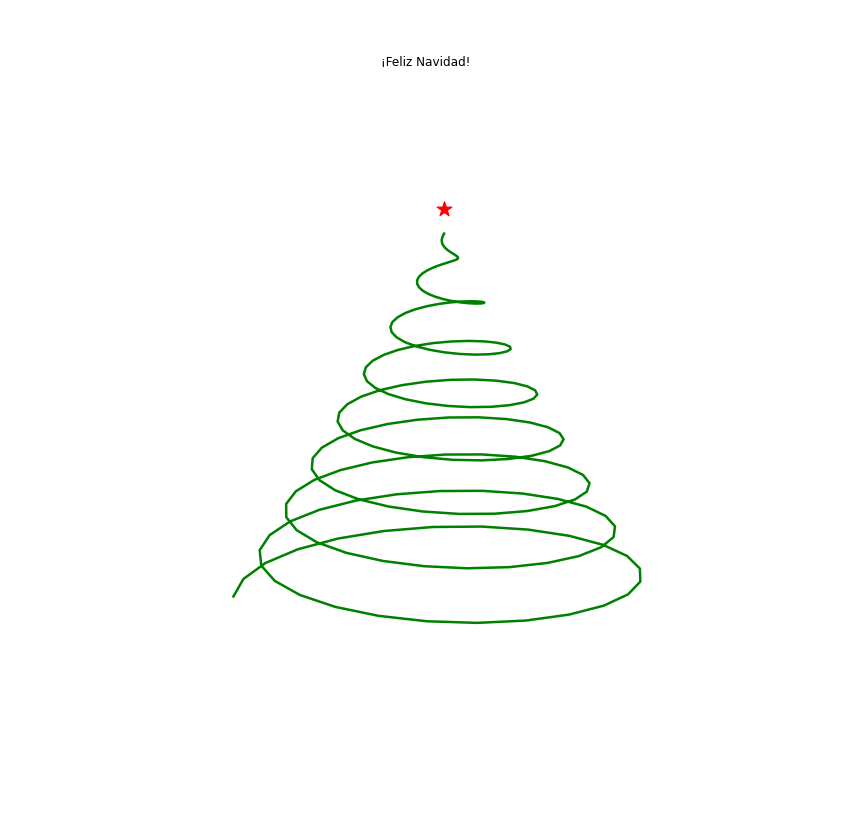

In [75]:
# Calculate spiral coordinates for the Xmas tree
theta = np.linspace(-8 * np.pi, 8 * np.pi, 200) 
z = np.linspace(-3, 0, 200)
r = 5
x = r * np.sin(theta)*z
y = r * np.cos(theta)*z
 
# Use matplotib and its OOP interface to draw it 
fig = plt.figure(figsize  = (15,15)) # Create figure
fig.set
ax = fig.gca(projection='3d') # It's a 3D Xmas tree!
ax.view_init(15, 0) # Set a nice view angle
ax._axis3don = False # Hide the 3d axes
 
# Plot the Xmas tree as a line
ax.plot(x, y, z,
        c='green', linewidth=2.5)
 
# Every Xmas tree needs a star
ax.scatter(0, 0, 0.2,
           c='red', s=250, marker='*')
 
# Type here your best whishes
ax.set_title(u"¡Feliz Navidad!")
 
plt.show()

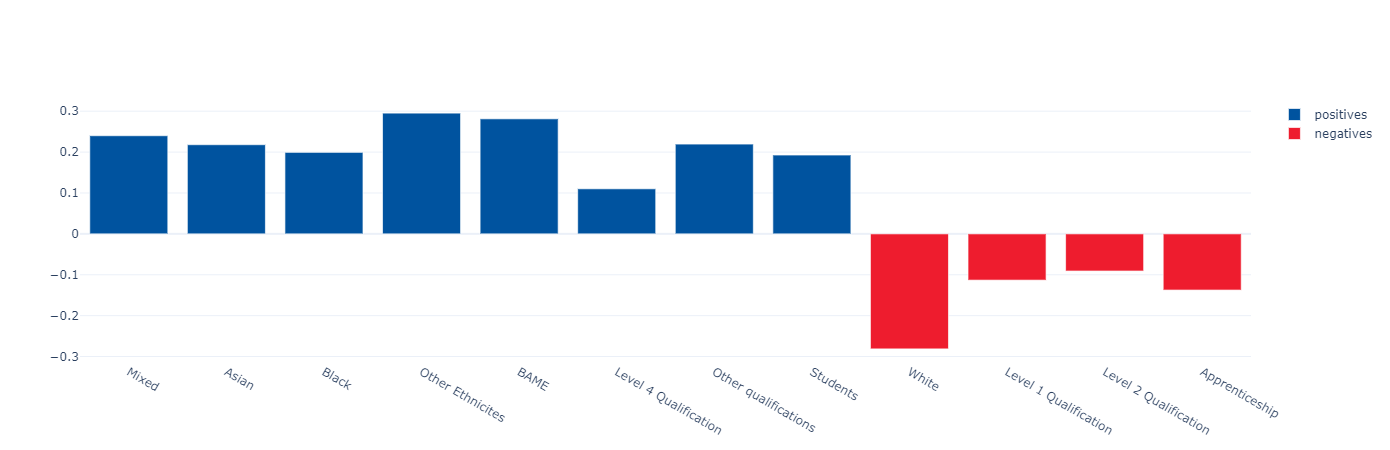

In [206]:
correl = [(group, stats.spearmanr(a = msoa_combined_year["representativeness_norm"], b = msoa_combined_year[group]).correlation) for group in (["annual_median_income_2011"] + ethnicities + education) if stats.spearmanr(a = msoa_combined_year["representativeness_norm"], b = msoa_combined_year[group]).pvalue < 0.05]

fig = go.Figure()
fig.add_trace(go.Bar(x=[label_processor(c[0]) for c in correl if c[1] >= 0], y=[c[1] for c in correl if c[1] >= 0],
                    marker_color= color_tesco_blue,
                    name='positives'))

fig.add_trace(go.Bar(x=[label_processor(c[0]) for c in correl if c[1] < 0], y=[c[1] for c in correl if c[1] < 0],
                    marker_color= color_tesco_red,
                    name='negatives'))

fig.update_layout(template = "plotly_white")
fig.show()
fig.write_html("../fierceeagle.github.io/_includes/Correlation_Representativness_Norm_White.html")

Writing HTML to Repo...
Ave Imperator, morituri te salutant
Adding new Files ...
Commiting Changes ...
Pulling previous Changes ... 
Pushing to Remote...
Finished


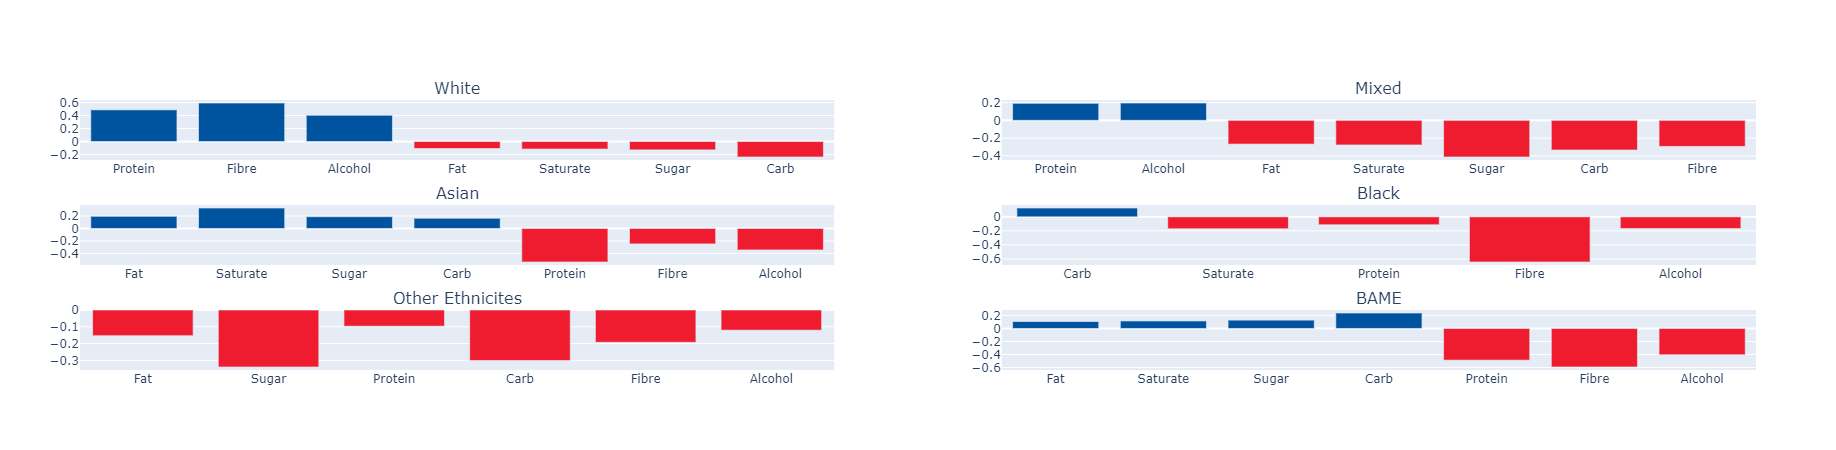

In [292]:
bar_plot_factory(dataframe = msoa_combined_year,
                 category_socio_economics = ethnicities,
                 category_nutrion = nutrients,
                 html_name = "Correlation_Nutirents_Ethnicity",
                 output_html = True,
                 auto_commit = True).show()

In [294]:
three_D_plot_factory(dataframe = msoa_combined_year,
                     x_axis ="annual_median_income_2011" ,
                     y_axis = "perc_ethnicity_white_2011",
                     title = "Interaction between Household Income, Ethnicity and Alcohol Consumption",
                     x_title = "Percentage White Inhabitants",
                     y_title = "Median Household Income",
                     z_title = "Kcal in the AAP by Alcohol",
                     aggfunc = np.mean, 
                     z_axis = "energy_alcohol",
                     html_name = "3D_Plot_White_Median_Income_Alcohol",
                     output_html = True,
                     auto_commit = True ,
                     quantiles = [0,.125,.25,.375,.5, .625,.75,.875,1]
                     ).show() 

Writing HTML to Repo...
Ave Imperator, morituri te salutant
Adding new Files ...
Commiting Changes ...
Pulling previous Changes ... 
Pushing to Remote...
Finished


In [295]:
three_D_multi_plot_factory(
                     dataframe = msoa_combined_year,
                     x_axis  ="annual_median_income_2011" ,
                     y_axis  = "perc_ethnicity_white_2011",
                     title   = "Interaction between Household Income, Ethnicity and Alcohol Consumption",
                     x_title = "Percentage White Inhabitants",
                     y_title = "Median Household Income",
                     z_title = "Kcal in the AAP by Alcohol",
                     aggfunc = np.mean, 
                     category_z  = ["f_spirits", "f_wine", "f_beer"],
                     html_name   = "3D_Multi_Plot_Test",
                     output_html = False,
                     auto_commit = True,
                     quantiles   = [0,.125,.25,.375,.5, .625,.75,.875,1],
                     ).show() 

In [296]:
# Genrates an interactive 3D Plot and generate an HTML 
def three_D_multi_plot_factory(dataframe,x_axis, y_axis, category_z ,quantiles, aggfunc, title = "", x_title ="",  y_title = "", z_title = ["",""], html_name = "", output_html = False, auto_commit = False):
    
    if len(category_z) > 3:
        cols = 2 
        rows = math.ceil(len(category_z)/2)
        [[{'is_3d': True},{'is_3d': True}] for x in range(rows)]
    else:
        cols = len(category_z)
        rows = 1
        specs = [[{'is_3d': True} for x in range(cols)]]
        
    fig = make_subplots(rows=rows, cols=cols,subplot_titles=(category_z), specs= specs, shared_xaxes = True, shared_yaxes = True)

    for z_axis, index in zip(category_z, it.product(range(1, rows + 1), range(1, cols + 1))) :
        slice_df = dataframe[[x_axis] + [y_axis] + [z_axis]].copy()
        slice_df[x_axis] = pd.qcut(x = slice_df[x_axis], q = quantiles)
        slice_df[y_axis] = pd.qcut(x = slice_df[y_axis], q = quantiles)
        pivot_slice_df = slice_df.pivot_table(index = x_axis,columns = y_axis, values = z_axis, aggfunc = aggfunc)

        imputer = KNNImputer(n_neighbors=3)
        pivot_slice_df = pd.DataFrame(imputer.fit_transform(pivot_slice_df), columns = pivot_slice_df.columns, index = pivot_slice_df.index)
        
        fig.add_trace(go.Surface(
                      z   = pivot_slice_df.values,
                      showlegend= False,
                      showscale=False,
                      ),row = index[0], col = index[1])
            
    fig.update_layout(title = title, 
                          scene = dict(
                                xaxis = dict(
                                    title = x_title,
                                    nticks = len(pivot_slice_df.columns.tolist()),
                                    tickvals = list(range(len(pivot_slice_df.columns.tolist()))), 
                                    ticktext= ["{:.1f}".format((x.left + x.right)/2) for x in pivot_slice_df.columns.tolist()]),
                                yaxis = dict(
                                    title = y_title,
                                    nticks = len(pivot_slice_df.index.tolist()),
                                    tickvals = list(range(len(pivot_slice_df.index.tolist()))), 
                                    ticktext= ["{:.0f}".format((x.left + x.right)/2) for x in pivot_slice_df.index.tolist()]),
                                zaxis_title= z_title),
                          margin=dict(r=40, b=40, l=40, t=40)) 
    
    fw=go.FigureWidget(fig)
    
    # So akward, but works better than everything else I tried.
    with fw.batch_update():
        for x in range(1,len(category_z)+1):
            fw.layout["scene" + str(x)] = scene = dict(
                                              xaxis = dict(
                                                title = x_title,
                                                nticks = len(pivot_slice_df.columns.tolist()),
                                                tickvals = list(range(len(pivot_slice_df.columns.tolist()))), 
                                                ticktext= ["{:.1f}".format((x.left + x.right)/2) for x in pivot_slice_df.columns.tolist()]),
                                              yaxis = dict(
                                                title = y_title,
                                                nticks = len(pivot_slice_df.index.tolist()),
                                                tickvals = list(range(len(pivot_slice_df.index.tolist()))), 
                                                ticktext= ["{:.0f}".format((x.left + x.right)/2) for x in pivot_slice_df.index.tolist()]),
                                              zaxis_title= z_title) 
                 
    if output_html:
        print("Writing HTML to Repo...")
        fig.write_html("../fierceeagle.github.io/_includes/"+ html_name+".html")
        print("Ave Imperator, morituri te salutant")
        
        # Calling Systems Command in a Jupyter Notebook (Trust me I am an Engineer)
        if auto_commit: 
            %cd -q ../fierceeagle.github.io/
            # Adds the Plot if new Name
            print("Adding new Files ...")
            !git add *.html
            print("Commiting Changes ...")
            !git commit -m"Added/Changed Plot" --quiet
            print("Pulling previous Changes ... ")
            !git pull --quiet
            print("Pushing to Remote...")
            !git push --quiet
            print("Finished")
    
    return fw

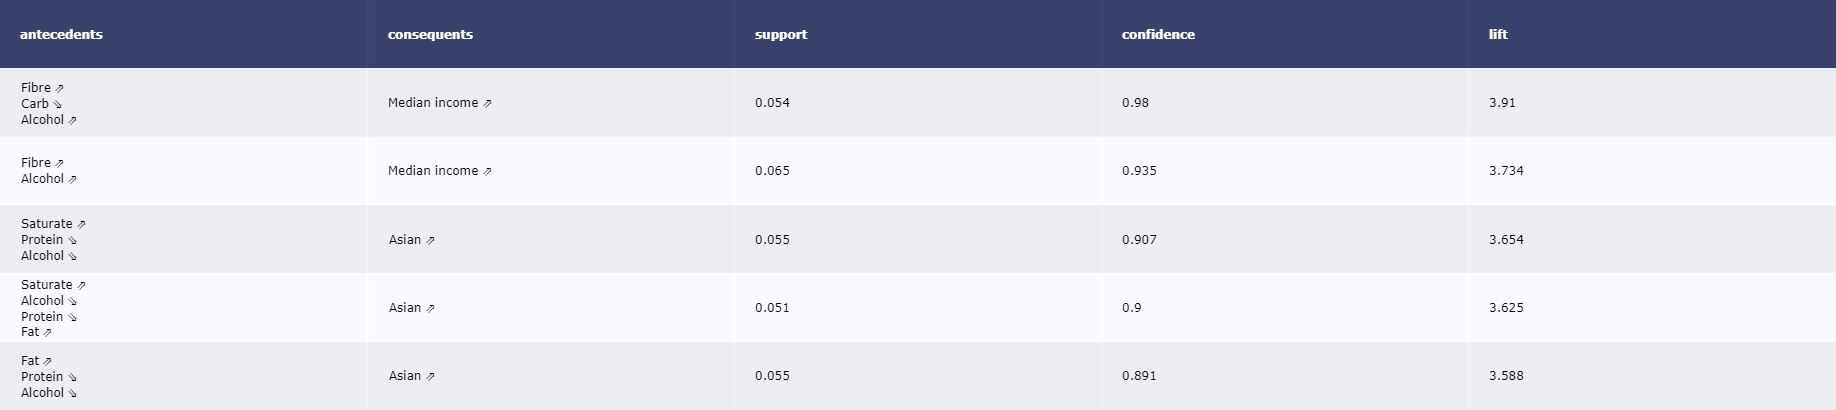

In [298]:
rules = rules_association[rules_association.apply(lambda x : True if x["antecedents"].issubset(nutrient_sets) and not x["consequents"].issubset(nutrient_sets) else False, axis = 1)].sort_values(by = "confidence", ascending = False).head(5)
rules["antecedents"] = rules.apply(lambda x: ''.join([x.capitalize() + "<br>" for x in list(x["antecedents"])]).replace("_high", u" \u21D7").replace("_low", u" \u21D8") , axis = 1)
rules["consequents"] = rules.apply(lambda x: ''.join([x.capitalize() + "<br>" for x in list(x["consequents"])]).replace("_high", u" \u21D7").replace("_low", u" \u21D8").replace("_", " "), axis = 1)
rules[["support","confidence", "lift"]] = rules[["support","confidence", "lift"]].applymap(lambda x : round(x,3))
rules = rules[["antecedents", "consequents", "support","confidence", "lift"]]
fig = ff.create_table(rules, height_constant=60)
fig.show()
fig.write_html("../fierceeagle.github.io/_includes/AssociationRuleTable_Nutrients.html")

In [315]:
baumbart = DecisionTreeClassifier()

X = msoa_combined_items[[x.split("_")[1] + "_Low" for x in nutrients] + [x.split("_")[1] + "_Low_to_Middle" for x in nutrients] + [x.split("_")[1] + "_Middle_to_High" for x in nutrients] + [x.split("_")[1] + "_High" for x in nutrients]]
y = msoa_combined_items["white_High"]

cross_val_score(estimator = baumbart, X = X, y = y, cv = 20, n_jobs = -1)

array([0.75555556, 0.84444444, 0.68888889, 0.62222222, 0.75555556,
       0.84444444, 0.84090909, 0.77272727, 0.84090909, 0.72727273,
       0.72727273, 0.75      , 0.70454545, 0.72727273, 0.84090909,
       0.77272727, 0.68181818, 0.70454545, 0.88636364, 0.84090909])

In [309]:
msoa_combined_items

,white_Low,white_Low_to_Middle,white_Middle_to_High,white_High,mixed_Low,mixed_Low_to_Middle,mixed_Middle_to_High,mixed_High,asian_Low,asian_Low_to_Middle,...,fibre_Middle_to_High,fibre_High,alcohol_Low,alcohol_Low_to_Middle,alcohol_Middle_to_High,alcohol_High,Median_Income_Low,Median_Income_Low_to_Middle,Median_Income_Middle_to_High,Median_Income_High
E02000001,False,False,False,True,False,True,False,False,False,False,...,True,False,False,False,False,True,False,False,False,True
E02000002,False,False,True,False,False,True,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False
E02000003,False,True,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
E02000004,False,False,False,True,True,False,False,False,True,False,...,False,False,True,False,False,False,False,False,True,False
E02000005,False,False,True,False,True,False,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02000977,False,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
E02000979,False,False,True,False,False,True,False,False,False,True,...,False,False,False,False,False,True,False,False,False,True
E02000980,False,False,True,False,False,True,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
E02000982,False,False,True,False,False,True,False,False,False,False,...,True,False,False,False,True,False,False,False,True,False


## Only Proper ML Following from here on out